In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
import seaborn as sns

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, auc, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.utils import shuffle


from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

### Load data

In [2]:
filename = '../../Dataset/heartbeatFeaturesB4.csv'
df = pd.read_csv(filename)
toremove = df.shape[1] -1 
df = df.iloc[:, 0:toremove]
df.head()

,stdPCA1,stdPCA2,stdPCA3,meanPCA1,meanPCA2,meanPCA3,meanS1,meanS2,stdS1,stdS2,...,minstdS1,maxstdS1,mmstdS1,minstdS2,maxstdS2,mmstdS2,posRatio,stdWavelet,meanWavelet,class
0,2.925073,1.603105,1.107265,-1.327246e-16,-2.224033e-17,2.511005e-18,472.0000,519.0000,26.57066,28.81666,...,24.65675,22.15827,20.00486,23.79636,25.31929,19.62142,0.086957,0.143258,-0.016102,Normal
1,3.003149,1.398531,1.245671,3.994780e-17,-5.461219e-17,-3.146381e-17,476.2105,480.1579,79.44780,79.73795,...,58.73258,79.29658,58.02636,60.56134,80.77381,61.31806,0.000000,0.164868,0.020342,Normal
2,2.906362,1.612006,1.189551,-2.873518e-17,4.745659e-17,1.567374e-17,489.6667,509.6250,21.94311,27.64023,...,16.47021,20.52481,14.64988,24.01983,24.41311,20.72116,0.000000,0.291671,-0.025297,Normal
3,2.915212,1.579173,1.217206,-1.107815e-17,-1.628307e-16,9.801752e-17,477.5000,491.7647,30.51374,17.26097,...,27.18428,28.52656,25.01699,14.72356,15.16122,12.24434,0.000000,0.077379,-0.000735,Normal
4,3.027328,1.368556,1.143924,-1.072735e-16,1.499522e-17,2.854859e-17,1364.5000,2427.0000,20.50610,0.00000,...,20.50610,20.50610,20.50610,0.00000,0.00000,0.00000,0.750000,0.064384,0.002975,Normal


# Some stats

In [3]:
df.shape

(312, 27)

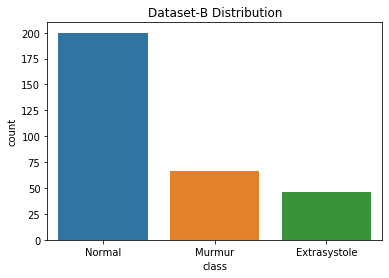

In [4]:
plot = sns.countplot(x='class', data=df).set_title('Dataset-B Distribution').get_figure()

### Back to reality

In [52]:
X = df.iloc[:,0:17]
X[['maxstdS1', 'maxstdS2', 'mmstdS1', 'mmstdS2']] = df[['maxstdS1', 'maxstdS2','mmstdS1', 'mmstdS2']]
X[['posRatio','stdWavelet','meanWavelet']] = df[['posRatio','stdWavelet','meanWavelet']]
#X[['posRatio']] = df[['posRatio']]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(x_scaled)
x_dim = X.shape[1]

#X.columns = ['stdPCA1', 'stdPCA2', 'stdPCA3', 'meanPCA1', 
#               'meanPCA2', 'meanPCA3', 'meanS1', 'meanS2', 'stdS1', 'stdS2','rebuilError', 'ratios','stdFFTSHA' ,'lenFFTSHA', 'stdlenFFTSHA' ,'lenstdFFTSHA' ,'posFFT'] 
X.columns = [ 'stdPCA1', 'stdPCA2', 'stdPCA3', 'meanPCA1', 
               'meanPCA2', 'meanPCA3', 'meanS1', 'meanS2', 
          'stdS1', 'stdS2','rebuilError', 'ratios','stdFFTSHA' ,
          'lenFFTSHA', 'stdlenFFTSHA' ,'lenstdFFTSHA' ,'posFFT',
         'maxstdS1', 'maxstdS2', 'mmstdS1', 'mmstdS2',
         'posRatio','stdWavelet','meanWavelet']
X.head()

,stdPCA1,stdPCA2,stdPCA3,meanPCA1,meanPCA2,meanPCA3,meanS1,meanS2,stdS1,stdS2,...,stdlenFFTSHA,lenstdFFTSHA,posFFT,maxstdS1,maxstdS2,mmstdS1,mmstdS2,posRatio,stdWavelet,meanWavelet
0,0.638786,0.409461,0.503370,0.263359,0.366913,0.404606,0.063191,0.047157,0.039061,0.026406,...,0.016750,0.028118,0.173913,0.032574,0.029471,0.029409,0.017980,0.096618,0.223323,0.222477
1,0.727809,0.236116,0.786586,0.446894,0.282429,0.320283,0.064612,0.039029,0.116794,0.073067,...,0.064188,0.006984,0.304348,0.116572,0.094018,0.085303,0.056188,0.000000,0.264409,0.318822
2,0.617452,0.417003,0.671749,0.373890,0.548808,0.437275,0.069153,0.045195,0.032258,0.025328,...,0.233871,0.001569,0.130435,0.030173,0.028416,0.021536,0.018988,0.000000,0.505492,0.198169
3,0.627543,0.389182,0.728339,0.392658,0.000000,0.641646,0.065047,0.041458,0.044858,0.015817,...,0.211261,0.001788,0.347826,0.041936,0.017647,0.036777,0.011220,0.000000,0.098073,0.263103
4,0.755378,0.210717,0.578384,0.290411,0.464090,0.469229,0.364380,0.446460,0.030146,0.000000,...,0.004540,0.105028,0.130435,0.030146,0.000000,0.030146,0.000000,0.833333,0.073366,0.272911


In [53]:
P = X.iloc[201:212,:]
print(P)

      stdPCA1   stdPCA2   stdPCA3  meanPCA1  meanPCA2  meanPCA3    meanS1  \
201  0.605587  0.440405  0.590961  0.497328  0.591634  0.377398  0.207027   
202  0.667965  0.333823  0.611073  0.263962  0.283690  0.334091  0.193833   
203  0.642047  0.365956  0.536380  0.445646  0.550433  0.365013  0.107298   
204  0.361043  0.643139  0.743146  0.506113  0.423515  0.653605  0.196296   
205  0.319600  0.682034  0.691328  0.429948  0.381655  0.286227  0.115498   
206  0.853685  0.116358  0.431276  0.213921  0.407205  0.323405  0.195056   
207  0.875026  0.112118  0.512734  0.330905  0.499508  0.531885  0.136295   
208  0.401275  0.631718  0.779641  0.399817  0.759952  1.000000  0.091819   
209  0.402381  0.604836  0.787658  0.415252  0.217976  0.574510  0.079895   
210  0.502751  0.517177  0.737842  0.428118  0.500556  0.501176  0.131253   
211  0.030662  1.000000  0.464186  0.317863  0.579161  0.880384  0.695267   

       meanS2     stdS1     stdS2  ...  stdlenFFTSHA  lenstdFFTSHA    posFF

In [7]:
y = df.iloc[:,toremove-1:toremove]
y.head()
#Y = pd.get_dummies(y['class'])

#Y.columns = ['Art','Normal', 'Murmur', 'Extr']
#Y.columns = ['Normal', 'Murmur', 'Extr']
#print(Y)

,class
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal


In [8]:
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
Y = encoder.transform(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Split data

In [9]:
X,Y = shuffle(X,Y,random_state=12)

In [10]:
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.20, random_state = 10)


In [11]:
train_outcome = pd.crosstab(index = Y_train, columns = "count")
test_outcome = pd.crosstab(index = Y_test, columns = "count")

print(train_outcome,'\n\n',test_outcome)

col_0  count
row_0       
0         42
1         52
2        155 

 col_0  count
row_0       
0          4
1         14
2         45


In [12]:
# Scaling

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [13]:
X_train.head()

,stdPCA1,stdPCA2,stdPCA3,meanPCA1,meanPCA2,meanPCA3,meanS1,meanS2,stdS1,stdS2,...,stdlenFFTSHA,lenstdFFTSHA,posFFT,maxstdS1,maxstdS2,mmstdS1,mmstdS2,posRatio,stdWavelet,meanWavelet
146,0.738730,0.254923,0.713839,0.579899,0.337349,0.521000,0.085126,0.109104,0.000000,0.032398,...,0.007228,0.065795,0.086957,0.000000,0.041152,0.000000,0.032398,0.000000,0.210870,0.156784
176,0.712087,0.372787,0.422174,0.356526,0.551233,0.047152,0.094997,0.102197,0.010069,0.094171,...,0.011358,0.041696,0.086957,0.008097,0.074068,0.009356,0.068683,0.123457,0.208246,0.203514
239,0.623460,0.336125,0.835758,0.437062,0.466014,0.399644,0.097162,0.156243,0.015442,0.330703,...,0.004075,0.117059,0.130435,0.011435,0.024052,0.015442,0.007127,0.277778,0.072809,0.280042
207,0.875026,0.112118,0.512734,0.330905,0.499508,0.531885,0.136295,0.125132,0.193026,0.318970,...,0.046579,0.009805,0.347826,0.178468,0.164952,0.177424,0.123039,0.686275,0.216852,0.274878
117,0.174614,0.738971,0.766150,0.195366,0.315445,0.374508,0.079474,0.091873,0.021518,0.046565,...,0.032375,0.014317,0.086957,0.018361,0.071605,0.018711,0.046565,0.138889,0.140781,0.247876


## The Model

In [14]:
model = XGBClassifier(objective='multi:softmax')

In [15]:
# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }
# gsearch1 = GridSearchCV(model, 
#  param_grid = param_test1,n_jobs=4,iid=False, cv=5)

# gsearch1.fit(X_train,Y_train)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [16]:
# params = {
#     "colsample_bytree": uniform(0.7, 0.3),
#     "gamma": uniform(0, 0.5),
#     "learning_rate": uniform(0.03, 0.3), # default 0.1 
#     "max_depth":range(3,10,2), # default 3
#     "n_estimators": randint(100, 150), # default 100
#     "subsample": uniform(0.6, 0.4),
#     'min_child_weight':range(1,6,2)
# }

# search = RandomizedSearchCV(model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=4,return_train_score=True)

# search.fit(X, Y)

# search.best_params_

In [17]:
# report_best_scores(search.cv_results_, 1)

In [18]:
# search.best_params_

In [19]:
model = XGBClassifier(objective='multi:softmax', colsample_bytree=0.9441385059120846,gamma= 0.34236558627693964,learning_rate=0.07878508180346738,max_depth=5,min_child_weight= 5, n_estimators=105, subsample = 0.9799199653167696)

In [20]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]

In [21]:
#Y_train.shape
#eval_metric=["merror", "mlogloss"],,eval_metric="auc" objective='multi:softmax',

In [22]:
model.fit(X_train, Y_train , early_stopping_rounds=5, eval_metric=["merror", "mlogloss"], eval_set=eval_set)#, verbose=True)

[0]	validation_0-merror:0.172691	validation_0-mlogloss:1.04106	validation_1-merror:0.31746	validation_1-mlogloss:1.05614
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 5 rounds.
[1]	validation_0-merror:0.144578	validation_0-mlogloss:0.989944	validation_1-merror:0.31746	validation_1-mlogloss:1.01625
[2]	validation_0-merror:0.15261	validation_0-mlogloss:0.94482	validation_1-merror:0.285714	validation_1-mlogloss:0.980335
[3]	validation_0-merror:0.156627	validation_0-mlogloss:0.902533	validation_1-merror:0.301587	validation_1-mlogloss:0.953025
[4]	validation_0-merror:0.148594	validation_0-mlogloss:0.864761	validation_1-merror:0.285714	validation_1-mlogloss:0.928821
[5]	validation_0-merror:0.15261	validation_0-mlogloss:0.827998	validation_1-merror:0.253968	validation_1-mlogloss:0.904559
[6]	validation_0-merror:0.156627	validation_0-mlogloss:0.79766	validation_1-merror:0.285714	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9441385059120846,
              gamma=0.34236558627693964, learning_rate=0.07878508180346738,
              max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
              n_estimators=105, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9799199653167696, verbosity=1)

# K Fold?

In [23]:
kfold = StratifiedKFold(n_splits=5, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(results)

Accuracy: 71.75% (5.02%)
[0.78125    0.66129032 0.67741935 0.69354839 0.77419355]


In [24]:
## predictions

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
print(y_pred)

[2 2 1 2 1 1 2 1 2 0 2 1 2 2 2 1 2 2 1 2 2 2 2 0 1 2 2 2 2 1 2 2 2 2 2 2 2
 2 0 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 0 0 2 0 2 2 1 2]


In [25]:
accuracy = accuracy_score(Y_test, predictions)

In [26]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.37%


In [27]:
print(Y_test)

[2 0 1 2 0 1 2 2 2 0 2 1 2 2 2 1 2 2 1 2 2 2 2 1 1 2 2 2 2 1 2 2 1 2 2 2 2
 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 0 1 2 2 2 2 1 2 1 2]


In [28]:
CM = confusion_matrix(Y_test, y_pred)
print(CM)

[[ 1  2  1]
 [ 1  9  4]
 [ 4  1 40]]


In [29]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.17      0.25      0.20         4
           1       0.75      0.64      0.69        14
           2       0.89      0.89      0.89        45

    accuracy                           0.79        63
   macro avg       0.60      0.59      0.59        63
weighted avg       0.81      0.79      0.80        63



In [30]:
results = model.evals_result()

In [31]:
ephocs = len(results['validation_0']['merror'])

In [32]:
x_axis = range(0, ephocs)

In [49]:
with open('./Logs/B_XGB_stats.log', 'a+') as f:
           f.write('\n======================12---10 Saved!========================================\n' + filename  +'\n\n' + str(CM) +'\n\n' + 'Dimensions: ' + str(x_dim) + '\n'+ 'Testing Accuracy: ' + str(000) + ' Training Acc: ' + str(000) + '\nTesting Score: '+ str(accuracy) + '\n\n' + classification_report(Y_test,y_pred))

### Plots

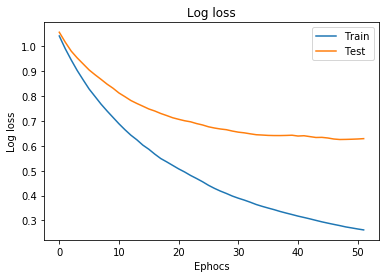

In [41]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label = 'Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label = 'Test')
ax.legend()
plt.ylabel('Log loss')
plt.xlabel('Ephocs')
plt.title('Log loss')
# model_name_ = '../../Models/XGB_Dataset_B_79_E17_V1'
# plt.savefig(model_name_ + '_lL_'+ '.jpg')
# plt.savefig(model_name_ + '_lL_'+ '.png')


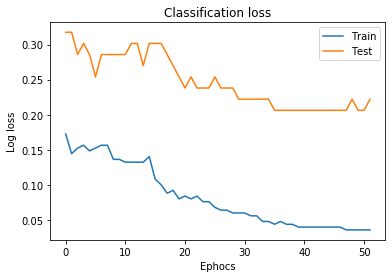

In [42]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label = 'Train')
ax.plot(x_axis, results['validation_1']['merror'], label = 'Test')
ax.legend()
plt.ylabel('Log loss')
plt.xlabel('Ephocs')
plt.title('Classification loss')
# plt.savefig(model_name_ + '_CL_'+ '.jpg')
# plt.savefig(model_name_ + '_CL_'+ '.png')
# plt.show()

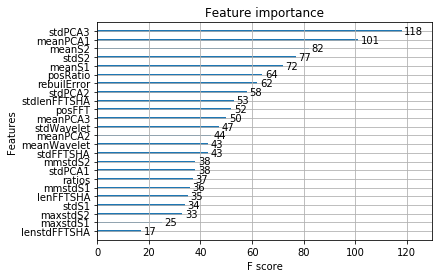

In [43]:
a = xgb.plot_importance(model)
# a.figure.savefig(model_name_ + '.jpg')
# a.figure.savefig(model_name_ + '.png')

In [37]:
import pickle

In [45]:
# # Saving the Model

# model_ = open(model_name_ + '.pkl', "wb")
# pickle.dump(model,model_)
# model_pkl = open(model_name_ + '.pkl', "rb")
# model_test = pickle.load(model_pkl)

In [55]:
model_test.predict(P)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [46]:
importances = model.feature_importances_

importances_ = importances.tolist()
labels = ['stdPCA1', 'stdPCA2', 'stdPCA3', 'meanPCA1', 
               'meanPCA2', 'meanPCA3', 'meanS1', 'meanS2', 
          'stdS1', 'stdS2','rebuilError', 'ratios','stdFFTSHA' ,
          'lenFFTSHA', 'stdlenFFTSHA' ,'lenstdFFTSHA' ,'posFFT',
         'maxstdS1', 'maxstdS2', 'mmstdS1', 'mmstdS2',
         'posRatio','stdWavelet','meanWavelet']

labels= pd.DataFrame(labels)
importances_ = pd.DataFrame(importances_)

FEAT_IMPORT = pd.concat([labels, importances_], axis = 1)

FEAT_IMPORT.columns = ['Features', 'Importances']
FEAT_IMPORT.sort_values(by=['Importances'], ascending = False)

,Features,Importances
2,stdPCA3,0.075800
0,stdPCA1,0.068115
10,rebuilError,0.064187
21,posRatio,0.056096
16,posFFT,0.045842
11,ratios,0.044549
9,stdS2,0.041932
12,stdFFTSHA,0.041457
14,stdlenFFTSHA,0.040287
15,lenstdFFTSHA,0.039567


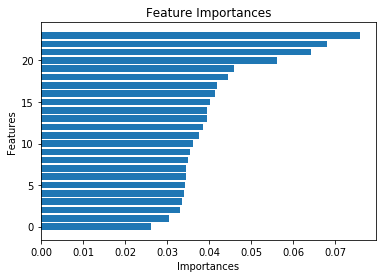

In [47]:
b = np.sort(model.feature_importances_)
plt.barh(range(len(FEAT_IMPORT)), np.sort(FEAT_IMPORT["Importances"]))
plt.ylabel('Features')
plt.xlabel('Importances')
plt.title("Feature Importances")
plt.show()